# converting depth map to cepton and velodyne point clouds 

Step 1 : take the depth image and estimate the transformation matrices for projection of 2D to 3D 

Step 2 : project each pixel from depth map image into the 3D point 

Step 3 : align the 2d scatter plot of generated point cloud with the velodyne point cloud scatter plot 

Step 4 : sample the new plot using the nearest neighbour 

Step 5 : Use the sampled plot to do the convert the original 3D point cloud into velo point cloud 


In [64]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime 
import os 
import cv2
import open3d as o3d
from PIL import Image 

In [65]:
# load caliberation files 
calib = pd.read_csv("000003.txt",delimiter=' ',header=None, index_col=0)
calib 


,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,-554.256258,0.000000,-9.600000e+02,-4.300553e+03,-4.408728e-14,554.256258,-3.600000e+02,-1612.707509,-1.224647e-16,0.000000,-1.000000e+00,-4.479743
P1:,-960.000000,0.000000,5.542563e+02,2.481850e+02,-3.600000e+02,554.256258,2.204364e-14,-372.477847,-1.000000e+00,0.000000,6.123234e-17,-1.034661
P2:,554.256258,0.000000,9.600000e+02,0.000000e+00,0.000000e+00,554.256258,3.600000e+02,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000
P3:,554.256258,0.000000,9.600000e+02,-4.434060e+02,0.000000e+00,554.256258,3.600000e+02,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000
P4:,960.000000,0.000000,-5.542563e+02,-2.234737e+03,3.600000e+02,554.256258,2.204364e-14,-372.476529,1.000000e+00,0.000000,6.123234e-17,-1.034657
P5:,554.256258,960.000000,5.878305e-14,2.399629e+04,0.000000e+00,960.000000,-5.542563e+02,23996.286392,0.000000e+00,1.000000,6.123234e-17,24.996132
R0_rect:,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,NaN,NaN,NaN
Tr_velo_to_p2:,0.000000,-1.000000,0.000000e+00,8.396190e-07,0.000000e+00,0.000000,-1.000000e+00,-0.500000,1.000000e+00,0.000000,0.000000e+00,-2.240217
imu_to_world:,0.018442,-0.999830,1.494694e-06,-5.405893e+01,9.996752e-01,0.018439,-1.759216e-02,15.623946,1.758914e-02,0.000326,9.998452e-01,0.050786


In [66]:
P_0 = np.array(calib.iloc[0]).reshape((3,4)).round(2)
P_1 = np.array(calib.iloc[1]).reshape((3,4)).round(2)
P_2 = np.array(calib.iloc[2]).reshape((3,4)).round(2)
P_3 = np.array(calib.iloc[3]).reshape((3,4)).round(2)
P_4 = np.array(calib.iloc[4]).reshape((3,4)).round(2)
P_5 = np.array(calib.iloc[5]).reshape((3,4)).round(2)
#R_0 = np.nan_to_num(np.array(calib.iloc[6]).reshape((3,3)).round(2), nan=0.0)
Tr = np.array(calib.iloc[7]).reshape((3,4)).round(2)
P2_to_w = np.array(calib.iloc[9]).reshape((3,4)).round(2)

R_0_rect = np.diag([1,1,1,1])#np.insert(R_0,3,values=[0,0,0,1],axis=0)
Tr_rect = np.insert(Tr,3,values=[0,0,0,1],axis=0)
#p_2_to_w = np.insert(P2_to_w,3,values=[0,0,0,1],axis=0)
print(P_2)
print(R_0_rect)
print(Tr_rect)

[[554.26   0.   960.     0.  ]
 [  0.   554.26 360.     0.  ]
 [  0.     0.     1.     0.  ]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[ 0.   -1.    0.    0.  ]
 [ 0.    0.   -1.   -0.5 ]
 [ 1.    0.    0.   -2.24]
 [ 0.    0.    0.    1.  ]]


In [67]:
print(P2_to_w)

[[-1.000e+00 -0.000e+00  2.000e-02 -5.402e+01]
 [ 2.000e-02  2.000e-02  1.000e+00  1.783e+01]
 [ 0.000e+00 -1.000e+00  2.000e-02  2.130e+00]]


In [68]:
p2_homo = np.insert(P_0,3,values=[0,0,0,1],axis=0)
p2_inv = np.linalg.inv(p2_homo)
tr_inv = np.linalg.inv(Tr_rect)
#p2_to_w_inv = np.linalg.inv(p_2_to_w)
projection_2d_to_3d = tr_inv.dot(p2_inv)#1*P2_to_w #tr_inv.dot(p2_inv)

In [153]:
from image_converter import depth_to_array
from inverse_project import *

In [155]:
# depth map images are RGBd

lidar_path = "/home/divyanshu/3d_detection/AIO/aiodrive_depth_mini/depth_0"
image_path =  "/home/divyanshu/3d_detection/AIO/aiodrive_image_mini/image_0"
filename = "000003.png"
#img = np.array(Image.open("depth_000003.png"))

pointcloud = depth_to_pointcloud(os.path.join(image_path, filename), os.path.join(lidar_path, filename))
#vizualize(point_cloud)
np.save("point_cloud.npy", np.asarray(pointcloud))



In [149]:
x = pointcloud[0,:]
y = pointcloud[1,:]
z = pointcloud[2,:]

phi = np.arccos((z/np.sqrt(x*x + y*y + z*z)))
theta = np.arctan(y/x)
r = np.sqrt(x*x + y*y + z*z)

/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


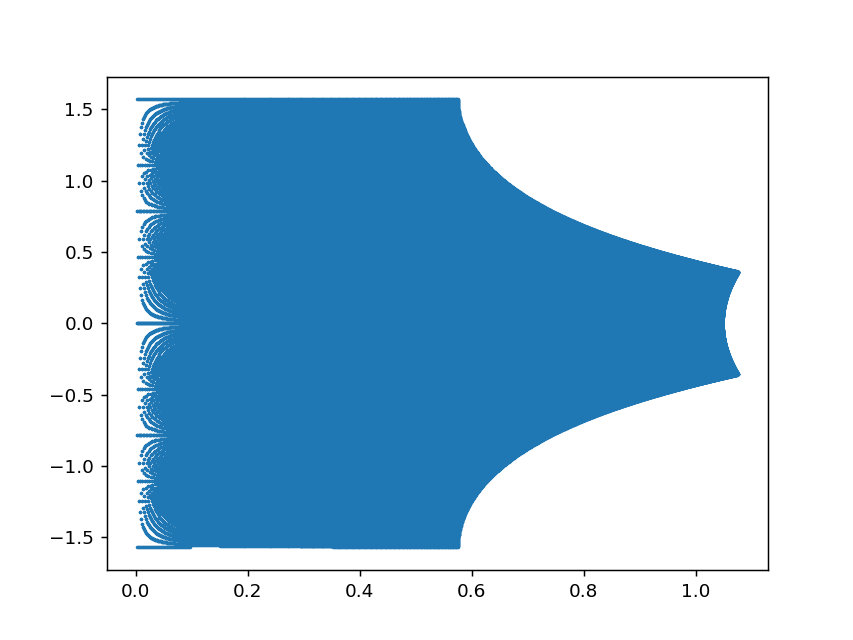

In [150]:
plt.scatter(phi, theta, s=0.8)
plt.show()

In [152]:
np.save("r.npy", r)

## use the cepton mask and generate the cepton point cloud from depth point cloud 

In [74]:
# load the cepton leaf 

leaf_phi = np.load('leaf_phi.npy')
leaf_theta = np.load('leaf_theta.npy')


In [73]:
def generate_mask(leaf_phi, leaf_theta, shape, overlap_horizontal, overlap_vertical, diff_vertical, diff_horizontal):
    
    rows, cols = shape
    mask_theta = []
    mask_phi = []
    
    for col in range(1,cols+1):
        for row in range(1,rows+1):
            updated_phi = leaf_phi  + col*(diff_horizontal*(1-overlap_horizontal))
            mask_phi = list(mask_phi) + list(updated_phi)
            updated_theta = leaf_theta - row*(diff_vertical*(1-overlap_vertical))
            mask_theta =  list(mask_theta) + list(updated_theta)
            
    return mask_phi, mask_theta    
    

In [98]:
overlap_horizontal = 0.1
overlap_vertical = 0
diff_vertical = max(leaf_theta) - min(leaf_theta)
diff_horizontal = max(leaf_phi) - min(leaf_phi)

mask_phi, mask_theta = generate_mask(leaf_phi, leaf_theta, (20,4), overlap_horizontal, overlap_vertical, diff_vertical, diff_horizontal)

<IPython.core.display.Javascript object>


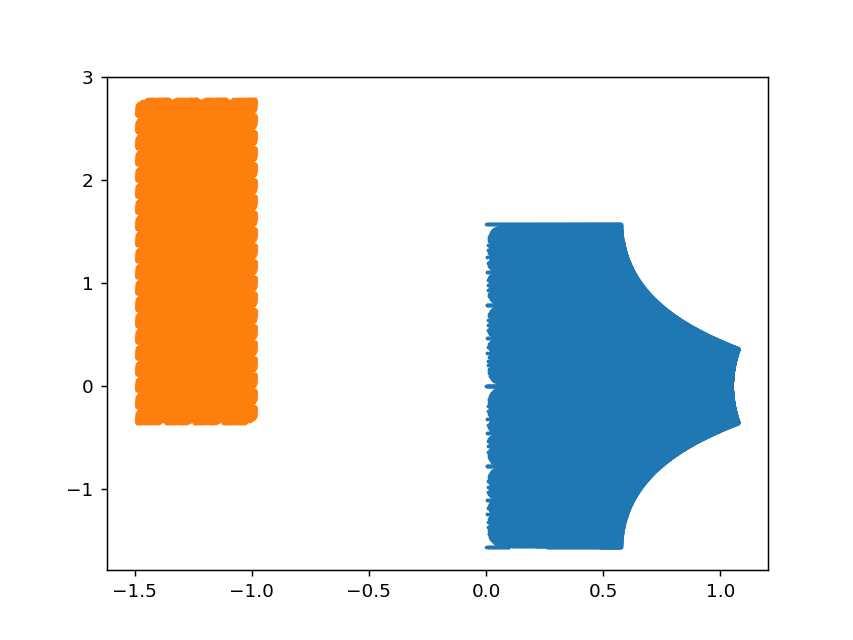

In [129]:
plt.scatter(phi, theta, s=0.8)
plt.scatter(np.asarray(mask_phi)-1.5, np.asarray(mask_theta)+1.2, s=0.8)
plt.show()

In [107]:
# do the nearest neighebour sampling 
mask_phi = np.asarray(mask_phi)-1.5
mask_theta = np.asarray(mask_theta)+1.2

np.save('mask_phi.npy', mask_phi)
np.save('mask_theta.npy', mask_theta)
np.save('theta.npy', np.asarray(theta))
np.save('phi.npy', np.asarray(phi))

In [108]:
from sklearn.neighbors import NearestNeighbors


In [110]:
mask = np.zeros((len(mask_phi), 2))
mask[:,0] = mask_phi
mask[:,1] = mask_theta

neigh = NearestNeighbors(n_neighbors=1, radius=0.4, algorithm = 'kd_tree')
neigh.fit(mask)


NearestNeighbors(algorithm='kd_tree', n_neighbors=1, radius=0.4)

In [112]:
neigh.kneighbors([[mask_theta[50],mask_phi[50]]], 1, return_distance=True)

(array([[0.92144528]]), array([[50904]]))

In [114]:
points = np.zeros((len(phi), 2))
points[:,0] = phi
points[:,1] = theta

In [120]:
print(points[50,:])
print(phi[50])
print(theta[50])

dist, idnex = neigh.kneighbors([points[50,:]], 1, return_distance=True)

[1.05547623 0.37671133]
1.0554762303310121
0.3767113289180633


In [125]:
print(dist[0][0])
print(idnex[0][0])

0.5414247291535413
49440


In [28]:
# compare the generated point cloud with cepton point cloud  

# get the angles for cepton lidar 
pcd = o3d.io.read_point_cloud("2/100.pcd")
cepton_arr = np.asarray(pcd.points)  

x_cepton = cepton_arr.T[0,:]
y_cepton = cepton_arr.T[1,:]
z_cepton = cepton_arr.T[2,:]

phi_cepton = np.arccos((z_cepton/np.sqrt(x_cepton*x_cepton + y_cepton*y_cepton + z_cepton*z_cepton)))
nan_index = ~np.isnan(phi_cepton)

theta_cepton = np.arctan(x_cepton/y_cepton)
nan_index_theta = ~np.isnan(theta_cepton)

r_cepton = np.sqrt(x_cepton*x_cepton + y_cepton*y_cepton + z_cepton*z_cepton)
nan_index_r = ~np.isnan(r_cepton)



filtered_phi_cepton = phi_cepton[nan_index]
filtered_theta_cetpton = theta_cepton[nan_index_theta]
filtered_r_cepton = r_cepton[nan_index_theta]

/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


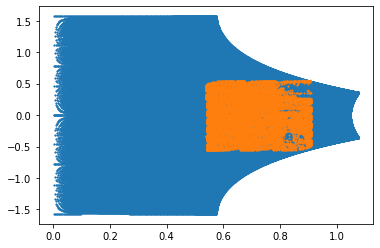

In [35]:
plt.scatter(phi, theta, s=0.8)
plt.scatter(filtered_phi_cepton-0.85, filtered_theta_cetpton, s=0.8)
plt.show()

In [36]:
# compare the generated point cloud with the velo point cloud 
# get the angles for velodyne lidar 
velo_path = "/home/divyanshu/3d_detection/AIO/aiodrive_lidar_velodyne_mini/lidar_velodyne"

velo_frame_1 = np.fromfile(os.path.join(velo_path,"000003.bin"), dtype=np.float32).reshape((-1,4))
#velo_frame_2 = np.fromfile(os.path.join(velo_path,"000002.bin"), dtype=np.float32).reshape((-1,4))


# load the points and remove reflectance, convert to homogenous 
points_1 = velo_frame_1[:, 0:3]
velo_1 = np.insert(points_1,3,1,axis=1).T

# take only the front FOV 
velo_1 = np.delete(velo_1,np.where(velo_1[0,:]<0),axis=1)
x = velo_1[0,:]
y = velo_1[1,:]
z = velo_1[2,:]

# convert cartesian coordinates into spherical coordinates and calculate phi and theta
phi_velo = np.arccos((z/np.sqrt(x*x + y*y + z*z)))
theta_velo = np.arctan(y/x)
r_velo = np.sqrt(x*x + y*y + z*z)

/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


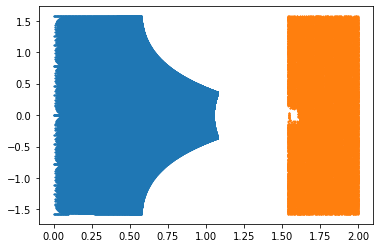

In [37]:
plt.scatter(phi, theta, s=0.8)
plt.scatter(phi_velo, theta_velo, s=0.8)
plt.show()

## conversion of point cloud using sampling of the point from 2D scatter plots 


In [40]:
# conversion to cepton point cloud using nearest neighbour 
filtered_phi_cepton = filtered_phi_cepton-0.85
filtered_theta_cetpton = filtered_theta_cetpton*1

unique_phi_cepton = np.unique(filtered_phi_cepton)
unique_theta_cepton = np.unique(filtered_theta_cetpton)




In [59]:
print(len(phi))

1094807


In [60]:
sampled_pointcloud = []
threshold = 0.005

for index in range(len(phi)):
    # find the closest angle 
    diff_phi = min(np.abs(unique_phi_cepton - phi[index]))
    diff_theta = min(np.abs(unique_theta_cepton - theta[index]))
    if (diff_phi<=threshold)&(diff_theta<=threshold):
        # add the point to the point cloud 
        sampled_pointcloud.append(pointcloud[:,index])
        
        

KeyboardInterrupt: 

In [144]:
## vizualize the point cloud 

array = np.load("sampled_pointcloud_from_cepton_mask_tresh_005.npy")


pcd_cam = o3d.geometry.PointCloud()
pcd_cam.points = o3d.utility.Vector3dVector(array)
# Flip it, otherwise the pointcloud will be upside down
#pcd_cam.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#o3d.visualization.draw_geometries([pcd_cam])


(244271, 3)


In [145]:
theta = np.load("theta.npy")
phi = np.load("phi.npy")
mask_theta = np.load("mask_theta.npy")
mask_phi = np.load("mask_phi.npy")

<IPython.core.display.Javascript object>


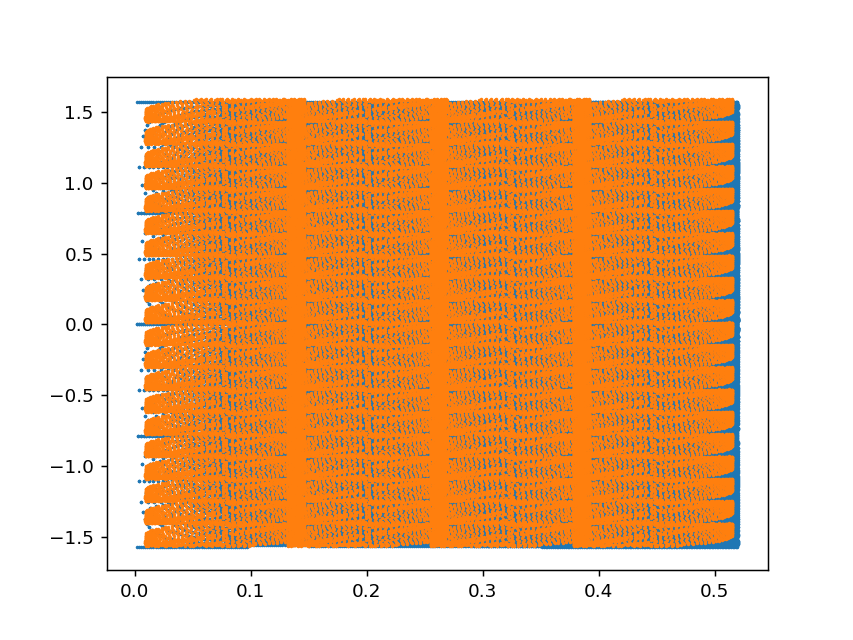

In [146]:
phi2 = phi[phi<0.52]
theta2 = theta[phi<0.52]

plt.scatter(phi2, theta2, s=0.8)
plt.scatter(mask_phi, mask_theta, s=0.8)
plt.show()